<h1>SARL Complete Training (IL + RL)</h1>

Import the necessary packages

In [1]:
from jax import random, device_get
import jax.numpy as jnp
import optax
import numpy as np
import time
import matplotlib.pyplot as plt

from socialjym.envs.socialnav import SocialNav
from socialjym.policies.sarl import SARL
from socialjym.utils.replay_buffers.uniform_vnet_replay_buffer import UniformVNetReplayBuffer
from socialjym.utils.rollouts.deep_vnet_rollouts import deep_vnet_rl_rollout, deep_vnet_il_rollout
from socialjym.utils.aux_functions import epsilon_scaling_decay, plot_state, plot_trajectory, test_k_trials
from socialjym.utils.rewards.reward1 import generate_reward_done_function

/home/tommasovan/PyVenvs/socialjym/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the training hyperparameters

In [2]:
random_seed = 1
il_training_episodes = 3_000
il_learning_rate = 0.001 # For SARL this has to be lower than for CADRL
il_num_epochs = 50 # Number of epochs to train the model after ending IL
rl_training_episodes = 10_000
rl_learning_rate = 0.001 # For SARL this has to be lower than for CADRL
rl_num_batches = 100 # Number of batches to train the model after each RL episode
batch_size = 100 # Number of experiences to sample from the replay buffer for each model update
epsilon_start = 0.5
epsilon_end = 0.1
epsilon_decay = 4_000
buffer_size = 100_000 # Maximum number of experiences to store in the replay buffer (after exceeding this limit, the oldest experiences are overwritten with new ones)
target_update_interval = 50 # Number of episodes to wait before updating the target network for RL (the one used to compute the target state values)
humans_policy = 'hsfm'
scenario = 'hybrid_scenario'

Set the reward and environment parameters

In [3]:
# Reward function parameters
reward_params = {
    'goal_reward': 1.,
    'collision_penalty': -0.25,
    'discomfort_distance': 0.2,
    'time_limit': 50.,
}

# Initialize reward function
reward_function = generate_reward_done_function(**reward_params)

# Environment parameters
env_params = {
    'robot_radius': 0.3,
    'n_humans': 5, # SARL can be trained with multiple humans
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': False,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
}

Initialize environment, robot policy and replay buffer

In [4]:
# Initialize environment
env = SocialNav(**env_params)

# Initialize robot policy and vnet params
policy = SARL(env.reward_function, dt=env_params['robot_dt'])
initial_vnet_params = policy.model.init(random.key(random_seed), jnp.zeros((env.n_humans, policy.vnet_input_size,)))

# Initialize replay buffer
replay_buffer = UniformVNetReplayBuffer(buffer_size, batch_size)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


<h2>Imitation Learning</h2>

Initialize the optimizer and the buffer state dictionary (where experiences will be stored)

In [5]:
# Initialize IL optimizer
optimizer = optax.sgd(learning_rate=il_learning_rate, momentum=0.9)

# Initialize buffer state
buffer_state = {
    'vnet_inputs': jnp.empty((buffer_size, env.n_humans, policy.vnet_input_size)),
    'targets': jnp.empty((buffer_size,1)),
}

Set all the parameters for the imitation learning rollout

In [6]:
il_rollout_params = {
    'initial_vnet_params': initial_vnet_params,
    'train_episodes': il_training_episodes,
    'random_seed': random_seed,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': 0,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_epochs': il_num_epochs,
    'batch_size': batch_size,
    'time_limit': reward_params['time_limit'],
}

During imitation learning, the robot will move using the same policy used by humans. Let's start the rollout.

In [7]:
il_out = deep_vnet_il_rollout(**il_rollout_params)

Simulating IL episodes...


Running for 3,000 iterations: 100%|████████| 3000/3000 [00:14<00:00, 213.99it/s]


Buffer size after IL: 100000
Optimizing model on generated experiences for 50 epochs...


Running for 50 iterations: 100%|████████████████| 50/50 [03:44<00:00,  4.49s/it]


Now, we save the parameters we are interested in from the rollout output and we plot the discounted return over the IL training episodes and the loss over the optimization epochs.

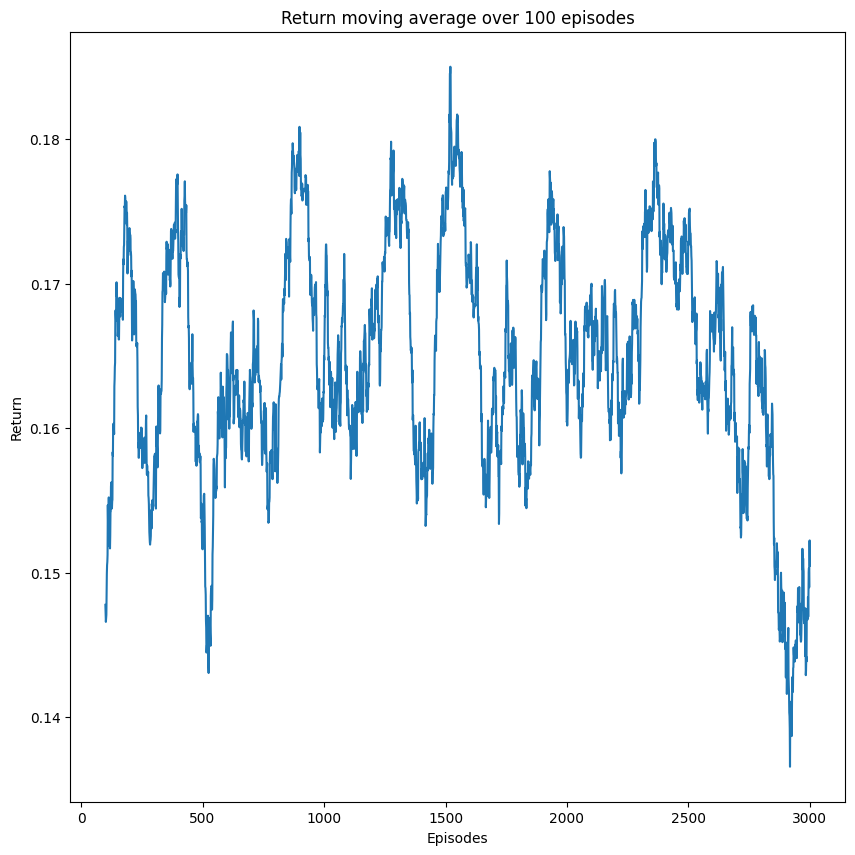

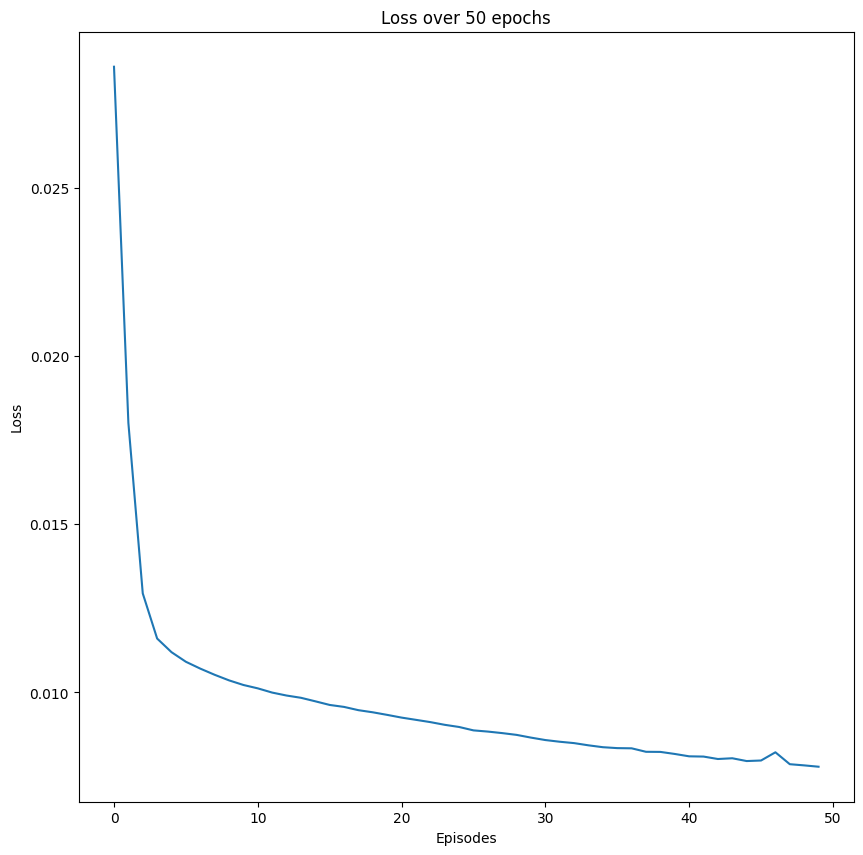

In [8]:
# Save the IL model parameters, buffer state, and keys
il_model_params = il_out['model_params']
reset_key = il_out['reset_key']
policy_key = il_out['policy_key']
buffer_state = il_out['buffer_state']
current_buffer_size = il_out['current_buffer_size']

# Plot the losses and returns
window = 100
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(il_out['returns'])-(window-1))+window, jnp.convolve(il_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss over {} epochs'.format(len(il_out['losses'])))
ax.plot(np.arange(len(il_out['losses'])), il_out['losses'])
plt.show()

Let's test the IL trained agent on 1000 unseen trials. The robot is still NOT visible by humans here.

In [9]:
test_k_trials(1000, 2, env, policy, il_model_params, reward_params["time_limit"])


Executing 1000 tests with 5 humans...


Running for 1,000 iterations: 100%|█████████| 1000/1000 [01:16<00:00, 13.16it/s]

RESULTS
Success rate: 1.00
Collision rate: 0.00
Timeout rate: 0.00
Average return: 0.08
SPL: 0.61
Average time to goal: 23.53 s
Average path length: 23.41 m
Average speed: 0.99 m/s
Average acceleration: 0.51 m/s^2
Average jerk: 3.82 m/s^3
Average space compliance: 0.96
Average minimum distance to humans: 0.71 m


{'average_acceleration': Array([0.525215  , 0.552259  , 0.4738778 , 0.5444856 , 0.7022804 ,
        0.5313391 , 0.6305674 , 1.1550009 , 0.8534988 , 0.58112115,
        0.40565   , 0.40884522, 0.3375687 , 0.48337647, 0.57453626,
        0.40747893, 0.341145  , 0.30551377, 0.38918102, 0.6713404 ,
        0.32966208, 0.44245872, 0.5486941 , 0.475307  , 0.323901  ,
        0.6895406 , 1.0995511 , 0.49999514, 0.4052226 , 0.44742623,
        0.5410716 , 0.5774476 , 0.97820026, 0.86156255, 1.1628555 ,
        0.75348246, 0.44781205, 0.3638439 , 0.4564425 , 0.4474262 ,
        0.40271357, 0.594956  , 0.43791103, 0.6321036 , 0.6384077 ,
        0.49614984, 0.6364516 , 0.44862333, 0.4371634 , 0.3069034 ,
        0.34542692, 0.3404709 , 0.35336486, 0.31501535, 0.6826797 ,
        0.41384384, 0.6461563 , 0.64784557, 0.692692  , 0.3990841 ,
        0.69605106, 0.5825724 , 0.3148271 , 0.683979  , 0.5335301 ,
        0.6014435 , 0.77700955, 0.53897345, 0.5042156 , 0.6411519 ,
        0.50428987, 0.72

<h2>Reinforcement Learning</h2>

Initialize the optimizer and the next rollout parameters. We should start from the model parameters compute after IL.

In [10]:
# Initialize RL optimizer
optimizer = optax.sgd(learning_rate=rl_learning_rate, momentum=0.9)

# Initialize RL rollout params
rl_rollout_params = {
    'initial_vnet_params': il_model_params,
    'train_episodes': rl_training_episodes,
    'random_seed': random_seed,
    'model': policy.model,
    'optimizer': optimizer,
    'buffer_state': buffer_state,
    'current_buffer_size': current_buffer_size,
    'policy': policy,
    'env': env,
    'replay_buffer': replay_buffer,
    'buffer_size': buffer_size,
    'num_batches': rl_num_batches,
    'epsilon_decay_fn': epsilon_scaling_decay,
    'epsilon_start': epsilon_start,
    'epsilon_end': epsilon_end,
    'decay_rate': epsilon_decay,
    'target_update_interval': target_update_interval,
    'time_limit': reward_params['time_limit'],
}

Let's start the RL rollout.

In [11]:
rl_out = deep_vnet_rl_rollout(**rl_rollout_params)

Running for 10,000 iterations: 100%|████| 10000/10000 [1:26:37<00:00,  1.92it/s]


Save the final model parameters and plot discounted return and loss over the RL training episodes.

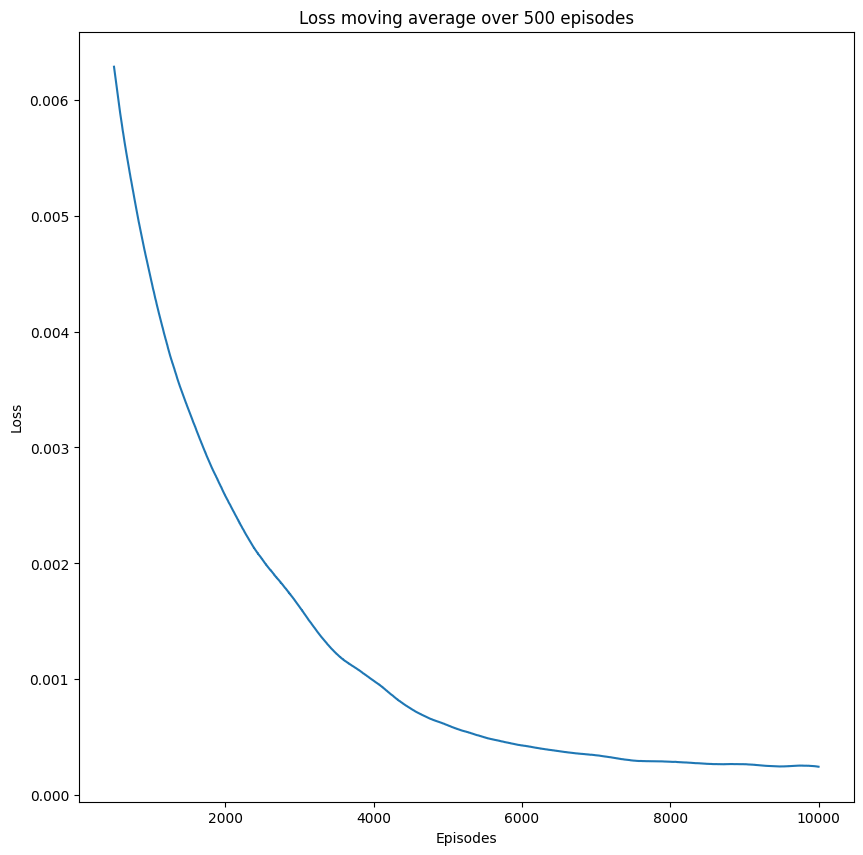

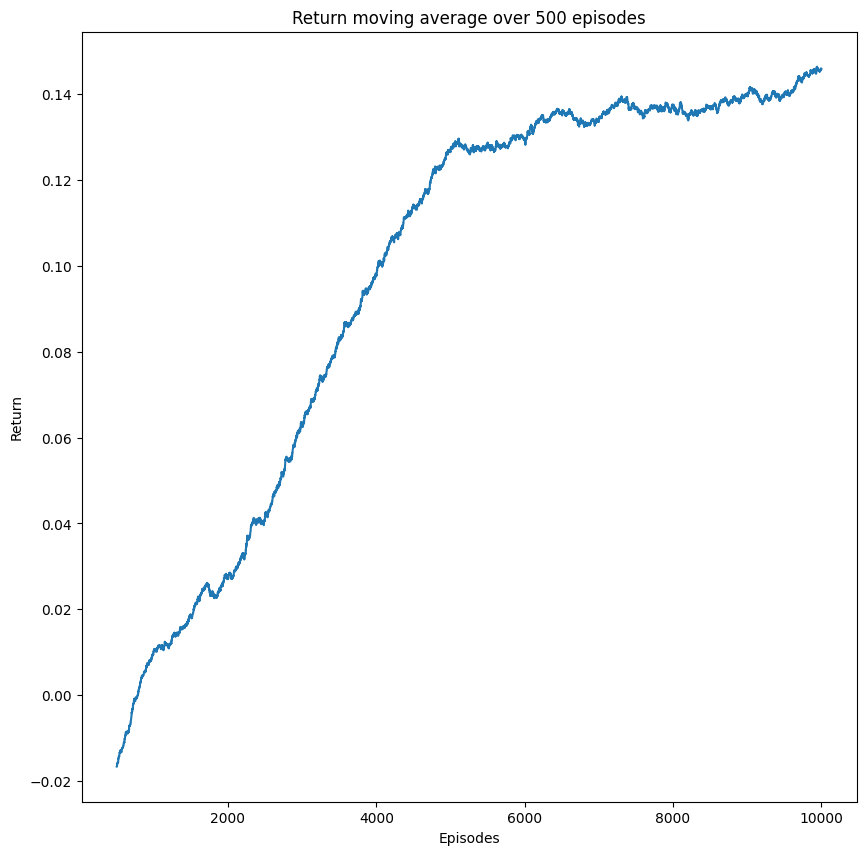

In [12]:
# Save the final model parameters and keys
final_model_params = rl_out['model_params']
reset_key = rl_out['reset_key']
policy_key = rl_out['policy_key']

figure, ax = plt.subplots(figsize=(10,10))
window = 500
ax.plot(np.arange(len(rl_out['losses'])-(window-1))+window, jnp.convolve(rl_out['losses'], jnp.ones(window,), 'valid') / window)
ax.set(xlabel='Episodes', ylabel='Loss', title='Loss moving average over {} episodes'.format(window))
plt.show()
figure, ax = plt.subplots(figsize=(10,10))
ax.set(xlabel='Episodes', ylabel='Return', title='Return moving average over {} episodes'.format(window))
ax.plot(np.arange(len(rl_out['returns'])-(window-1))+window, jnp.convolve(rl_out['returns'], jnp.ones(window,), 'valid') / window)
plt.show()

Let's test the RL trained agent in three environments, with 1, 5 and 10 humans. In all environmentss the robot is NOT visible.

In [13]:
env_params = {
    'robot_radius': 0.3,
    'n_humans': 5,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
}
env = SocialNav(**env_params)
env10_params = {
    'robot_radius': 0.3,
    'n_humans': 10,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
}
env10 = SocialNav(**env10_params)
env15_params = {
    'robot_radius': 0.3,
    'n_humans': 15,
    'robot_dt': 0.25,
    'humans_dt': 0.01,
    'robot_visible': True,
    'scenario': scenario,
    'humans_policy': humans_policy,
    'circle_radius': 7,
    'reward_function': reward_function,
}
env15 = SocialNav(**env15_params)
test_k_trials(1000, 3, env, policy, final_model_params, reward_params["time_limit"])
test_k_trials(1000, 3, env10, policy, final_model_params, reward_params["time_limit"])
test_k_trials(1000, 3, env15, policy, final_model_params, reward_params["time_limit"])


Executing 1000 tests with 5 humans...


Running for 1,000 iterations: 100%|█████████| 1000/1000 [00:53<00:00, 18.84it/s]


RESULTS
Success rate: 0.99
Collision rate: 0.00
Timeout rate: 0.01
Average return: 0.17
SPL: 0.86
Average time to goal: 16.80 s
Average path length: 16.47 m
Average speed: 0.98 m/s
Average acceleration: 0.79 m/s^2
Average jerk: 5.71 m/s^3
Average space compliance: 0.96
Average minimum distance to humans: 0.73 m

Executing 1000 tests with 10 humans...


Running for 1,000 iterations: 100%|█████████| 1000/1000 [02:14<00:00,  7.43it/s]


RESULTS
Success rate: 1.00
Collision rate: 0.00
Timeout rate: 0.00
Average return: 0.18
SPL: 0.89
Average time to goal: 16.16 s
Average path length: 15.93 m
Average speed: 0.99 m/s
Average acceleration: 0.71 m/s^2
Average jerk: 5.12 m/s^3
Average space compliance: 0.89
Average minimum distance to humans: 0.38 m

Executing 1000 tests with 15 humans...


Running for 1,000 iterations: 100%|█████████| 1000/1000 [03:45<00:00,  4.43it/s]

RESULTS
Success rate: 1.00
Collision rate: 0.00
Timeout rate: 0.00
Average return: 0.18
SPL: 0.88
Average time to goal: 16.23 s
Average path length: 16.02 m
Average speed: 0.99 m/s
Average acceleration: 0.73 m/s^2
Average jerk: 5.22 m/s^3
Average space compliance: 0.82
Average minimum distance to humans: 0.26 m


{'average_acceleration': Array([0.5290585 , 1.061858  , 0.9859575 , 0.7963531 , 1.3131617 ,
        0.5424013 , 0.49285966, 1.0841062 ,        nan, 0.722407  ,
        0.6878618 , 0.90914553, 0.623347  , 0.7268122 , 0.67131484,
        1.135663  , 1.1612339 , 0.7561642 , 0.9199062 , 0.4525423 ,
        0.5718461 , 0.9423192 , 0.6328592 , 0.9754053 , 0.6692499 ,
        1.1170393 , 0.93842787, 1.3050112 , 0.99138707, 0.71673083,
        0.8259461 , 0.97366154, 0.6202906 , 0.40966415, 0.5376103 ,
        1.222569  , 0.83252686, 0.71959585, 0.30990222, 0.80006164,
        0.77018464, 0.8367986 , 0.38910955, 0.82251024, 0.7610741 ,
        0.73813665, 0.31105393, 0.6895493 , 0.7111793 , 0.33444044,
        0.73415464, 0.61680573, 1.1039492 , 1.011822  , 0.8493761 ,
        0.7080417 , 1.0596936 , 0.65192544, 0.90905684, 0.8286318 ,
        1.3902146 , 0.25539088, 0.49322903, 0.8391383 , 0.36889794,
        0.39018053, 0.6883881 , 0.5586281 , 0.58075655, 1.082053  ,
        0.51023716, 0.93

Simulate some episodes using the trained agent.

Episode 0 ended - Execution time 1.99 seconds - Plotting trajectory...


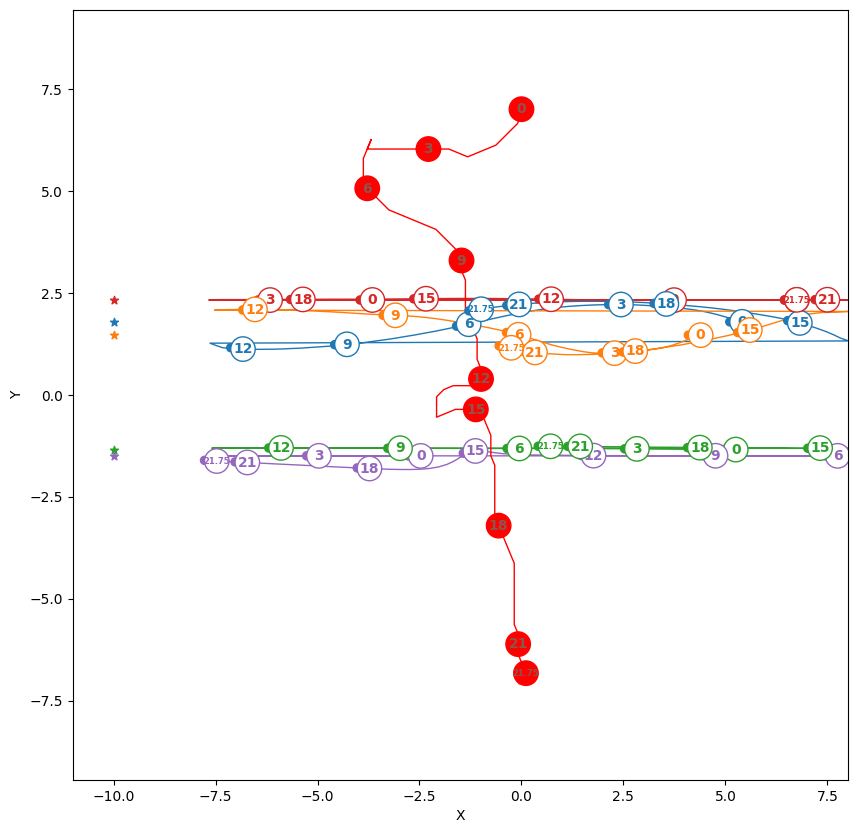

Episode 1 ended - Execution time 0.07 seconds - Plotting trajectory...


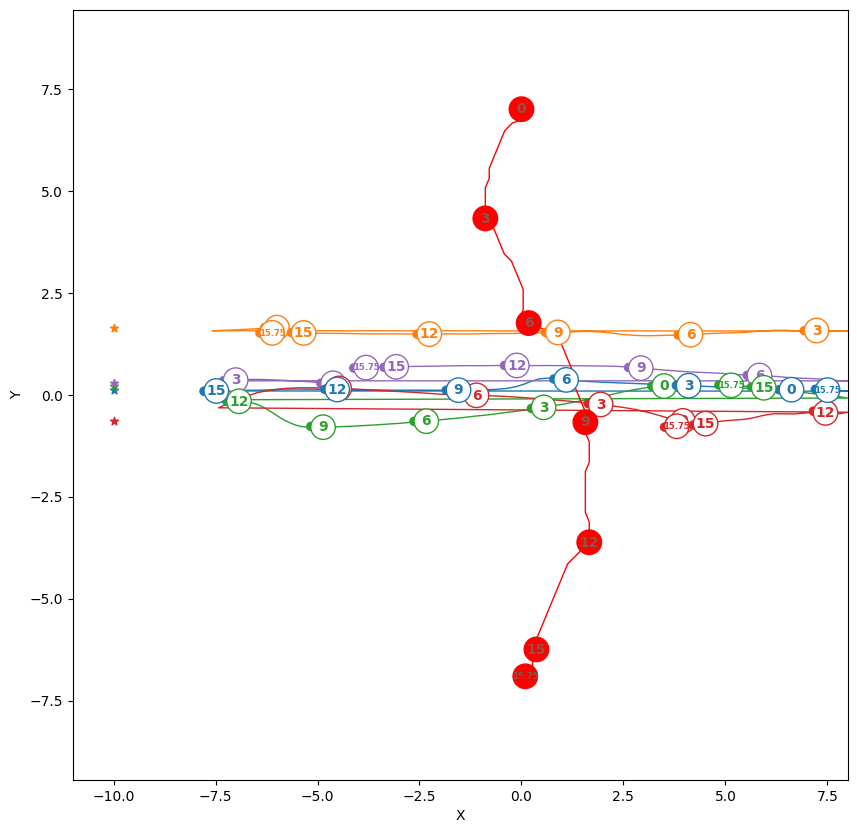

Episode 2 ended - Execution time 0.07 seconds - Plotting trajectory...


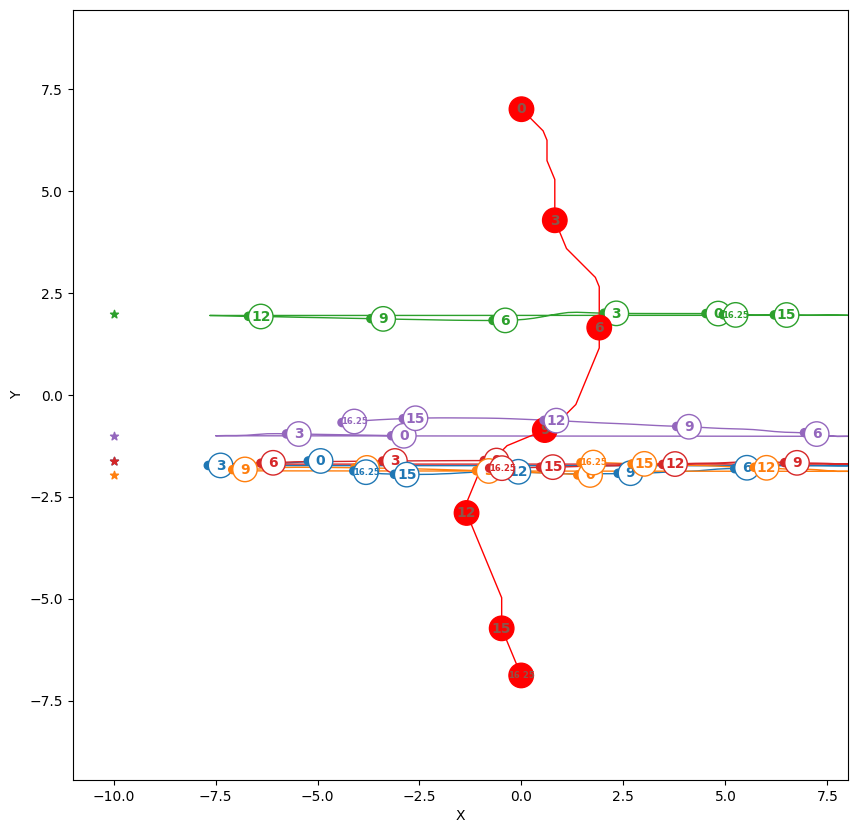

Episode 3 ended - Execution time 0.06 seconds - Plotting trajectory...


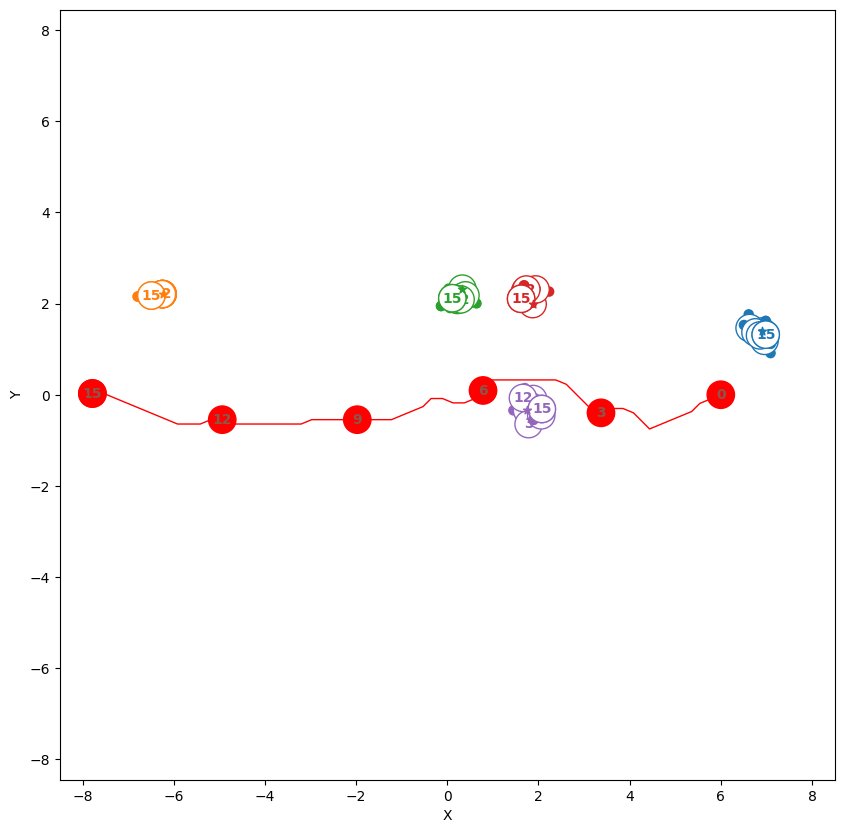

Episode 4 ended - Execution time 0.06 seconds - Plotting trajectory...


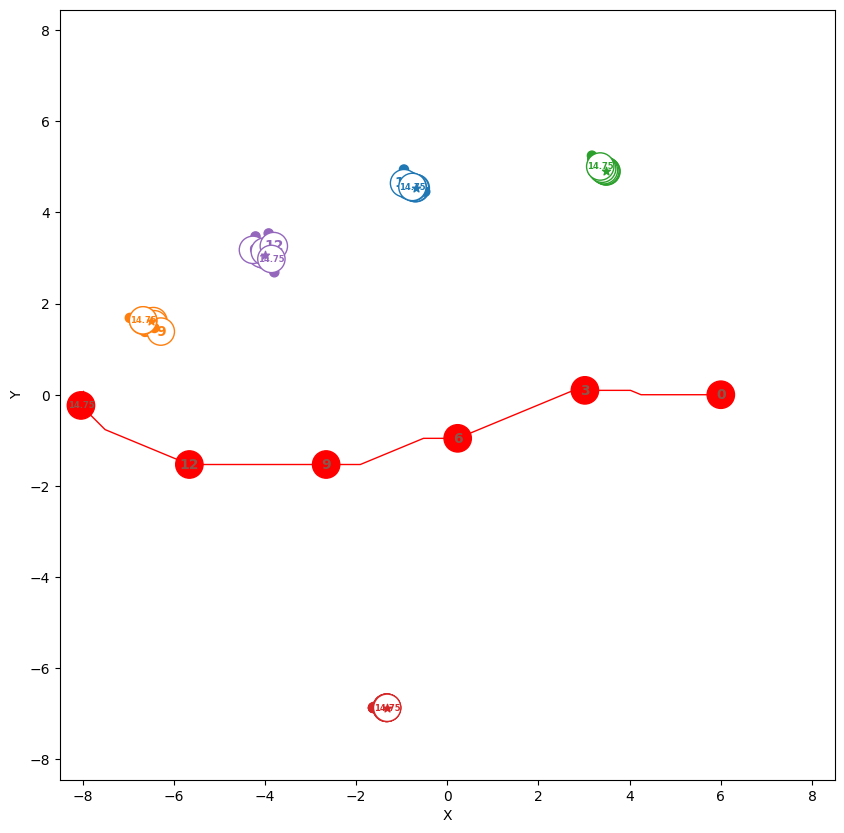

Average time per episode: 0.45 seconds
Total time for 5 episodes: 2.25 seconds


In [14]:
n_episodes = 5
env = SocialNav(**env_params)
# Simulate some episodes
episode_simulation_times = np.empty((n_episodes,))
for i in range(n_episodes):
    outcome = {"nothing": True, "success": False, "failure": False, "timeout": False}
    episode_start_time = time.time()
    state, reset_key, obs, info = env.reset(reset_key)
    all_states = np.array([state])
    while outcome["nothing"]:
        # action = jnp.array([0.,1.]) # Move north
        action, policy_key, _ = policy.act(policy_key, obs, info, final_model_params, 0.)
        state, obs, info, reward, outcome = env.step(state,info,action,test=True) 
        all_states = np.vstack((all_states, [state]))
    episode_simulation_times[i] = round(time.time() - episode_start_time,2)
    all_states = device_get(all_states) # Transfer data from GPU to CPU for plotting
    print(f"Episode {i} ended - Execution time {episode_simulation_times[i]} seconds - Plotting trajectory...")
    ## Plot episode trajectory
    figure, ax = plt.subplots(figsize=(10,10))
    ax.axis('equal')
    plot_trajectory(ax, all_states, info['humans_goal'], info['robot_goal'])
    for k in range(0,len(all_states),int(3/env_params['robot_dt'])):
        plot_state(ax, k*env_params['robot_dt'], all_states[k], env_params['humans_policy'], info['current_scenario'], info["humans_parameters"][:,0], env.robot_radius)
    # plot last state
    plot_state(ax, (len(all_states)-1)*env_params['robot_dt'], all_states[len(all_states)-1], env_params['humans_policy'], info['current_scenario'], info["humans_parameters"][:,0], env.robot_radius)
    plt.show()
# Print simulation times
print(f"Average time per episode: {round(np.mean(episode_simulation_times),2)} seconds")
print(f"Total time for {n_episodes} episodes: {round(np.sum(episode_simulation_times),2)} seconds")